In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import pandas as pd
import torch
from PIL import Image
from skimage.io import imshow

In [2]:
data_train = torchvision.datasets.VOCSegmentation('data',
                                         year='2012',
                                         image_set='val',
                                         download=False)

In [3]:
# Source: https://github.com/tue-robotics/image_recognition/blob/master/image_recognition_util/src/image_recognition_util/image_writer.py

def color_map(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap

In [4]:
cmap = color_map()[:, np.newaxis, :]

## Figure 1

In [23]:
# Parameters

np.random.seed(1)
n = len(data_train)
random_idx = np.random.randint(0, n-1, 8)

cam_dir = "experiment/baseline/baseline_cam_dir"

cam_path = sorted(os.listdir(cam_dir))

data_train_path = pd.read_csv("experiment/data_test.csv")['filename']
cam_eval_thres = 0.2

In [24]:
# First row: input_images
input_images = torch.zeros(*(4, 224, 224, 3), dtype=torch.int32)
for i in range(4):
    input_images[i, :, :, :] = torch.Tensor(np.array(data_train[random_idx[i]][0].resize((224, 224))).astype(int))
 
# Second row: cam_images
cam_images = torch.zeros(*(4, 224, 224, 3), dtype=torch.int32)
for i in range(4):
    id = os.path.splitext(os.path.basename(data_train_path.iloc[random_idx[i]]))[0]
    cam_dict = np.load(os.path.join(cam_dir, id + '.npy'), allow_pickle=True).item()
    cams = cam_dict['high_res']
    heatmap = cv2.applyColorMap(np.uint8(cams[0] * 255), cv2.COLORMAP_JET)
    cam_images[i, :, :, :] = torch.Tensor(cv2.resize(np.uint8(heatmap[...,::-1] * 0.4 + np.asarray(data_train[random_idx[i]][0]) * 0.50), (224,224)).astype(int))

# Thirs row: seg_images
seg_images = torch.zeros(*(4, 224, 224, 3), dtype=torch.int32)
for i in range(4):
    target = torch.Tensor(np.array(data_train[random_idx[i]][1].resize((224, 224))))
    target = target[:, :, np.newaxis]

    new_im = np.dot(target == 0, cmap[0])
    for _ in range(1, cmap.shape[0]):
        new_im += np.dot(target == _, cmap[_])
    new_im = Image.fromarray(new_im.astype(np.uint8)).convert('RGB')
    seg_images[i, :, :, :] = torch.Tensor(np.array(new_im))

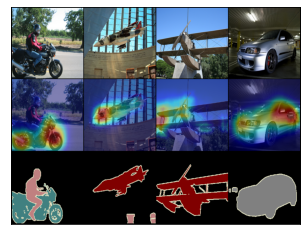

In [25]:
# Show

images = torch.cat((input_images, cam_images, seg_images), 0)

grid_img = torchvision.utils.make_grid(np.transpose(images, (0,3,1,2)), nrow=4)

plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

# torchvision.utils.save_image(grid_img / 255., 'Figure/Figure1.jpg')

# Figure 2

In [26]:
# Source: https://github.com/ecs-vlc/FMix

import torch
import torchvision
from torchvision import transforms
from torchvision.utils import save_image, make_grid

import numpy as np
from FMix.fmix import make_low_freq_image, binarise_mask

%matplotlib inline
import matplotlib.pyplot as plt

DECAY_POWER = 3
SHAPE = 224
LAMBDA = 0.5
NUM_IMAGES = 6

In [27]:
# Parameters

np.random.seed(1)
n = len(data_train)
random_idx = np.random.randint(0, n-1, 12)

cam_dir = "experiment/baseline/baseline_cam_dir"

cam_path = sorted(os.listdir(cam_dir))

data_train_path = pd.read_csv("experiment/data_test.csv")['filename']
cam_eval_thres = 0.2

In [28]:

# Batch
input_images = torch.zeros(*(12, 224, 224, 3), dtype=torch.int32)
for i in range(12):
    input_images[i, :, :, :] = torch.Tensor(np.array(data_train[random_idx[i]][0].resize((224, 224))).astype(int))
input_images=np.transpose(input_images, (0,3,1,2))
batch1 = input_images[:NUM_IMAGES]
batch2 = input_images[NUM_IMAGES:]

# Mask
soft_masks_np = [make_low_freq_image(DECAY_POWER, [SHAPE, SHAPE]) for _ in range(NUM_IMAGES)]
soft_masks = torch.from_numpy(np.stack(soft_masks_np, axis = 0)).float().repeat(1, 3, 1, 1)

# Mixup
masks_np = [binarise_mask(mask, LAMBDA, [SHAPE, SHAPE]) for mask in soft_masks_np]
masks = torch.from_numpy(np.stack(masks_np, axis = 0)).float().repeat(1, 3, 1, 1)

mix = batch1 * masks + batch2 * (1 - masks)

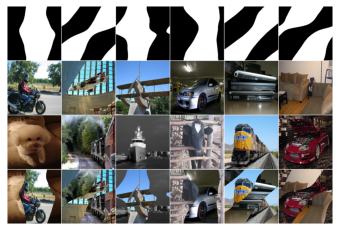

In [29]:
# Show

image = torch.cat((masks*255, batch1, batch2, mix), 0)

plt.imshow(make_grid(image/255., nrow=NUM_IMAGES, pad_value=1).permute(1, 2, 0).numpy())
_ = plt.axis('off')

# torchvision.utils.save_image(make_grid(image/255., nrow=NUM_IMAGES, pad_value=1), 'Figure2.jpg')

## Figure 3

In [ ]:
torchvision.utils.save_image(input_images[0] / 255., 'Figure/Sample1.jpg')
torchvision.utils.save_image(input_images[6] / 255., 'Figure/Sample2.jpg')

torchvision.utils.save_image(masks[0], 'Figure/Mask1.jpg')
torchvision.utils.save_image(1-masks[0], 'Figure/Mask2.jpg')
torchvision.utils.save_image(mix[0], 'Figure/FMix.jpg')

## Figure 4

In [208]:
# Show one CAM example

cam_images = torch.zeros(*(1, 224, 224, 3), dtype=torch.int32)
for i in range(1):
    id = os.path.splitext(os.path.basename(data_train_path.iloc[random_idx[i]]))[0]
    cam_dict = np.load(os.path.join(cam_dir, id + '.npy'), allow_pickle=True).item()
    cams = cam_dict['high_res']
    heatmap = cv2.applyColorMap(np.uint8(cams[0] * 255), cv2.COLORMAP_JET)
    cam_images[i, :, :, :] = torch.Tensor(cv2.resize(np.uint8(heatmap[...,::-1]), (224,224)).astype(int))
cam_images = np.transpose(cam_images, (0,3,1,2))

In [209]:
# torchvision.utils.save_image(cam_images[0] / 255., 'Figure/Heatmap1.jpg')

## Figure 6

In [13]:
n = len(data_train)
random_idx = [864, 318, 474, 143]

cam_dirs = ["experiment/baseline/baseline_cam_dir",
           "experiment/sce/sce_cam_dir",
           "experiment/sct/sct_cam_dir",
           "experiment/mixup/mixup_cam_dir",
           "experiment/manifold_mixup/manifold_mixup_cam_dir",
           "experiment/fmix/fmix_cam_dir",]

cam_paths = []
for cam_dir in cam_dirs:
    cam_paths.append(sorted(os.listdir(cam_dir)))

import pandas as pd

data_train_path = pd.read_csv("experiment/data_test.csv")['filename']
cam_eval_thres = 0.2

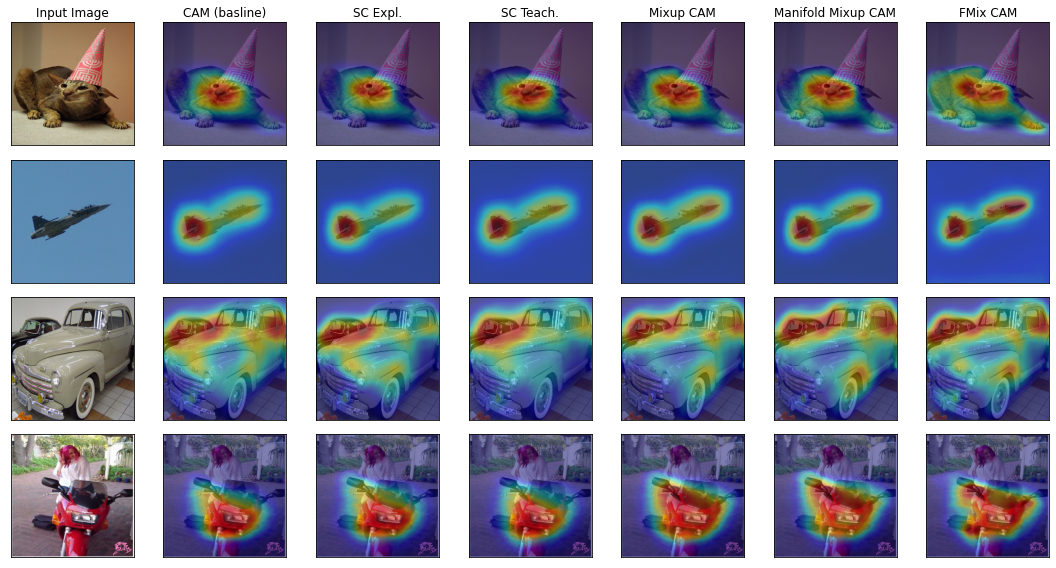

In [22]:
nrows = 4
ncols = 7

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,  figsize=(15, 8))
for i in range(nrows):
    for j in range(ncols):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
    ax[i, 0].imshow(data_train[random_idx[i]][0].resize((224, 224)), cmap=plt.cm.binary)
    
    id = os.path.splitext(os.path.basename(data_train_path.iloc[random_idx[i]]))[0]
    for k in range(1, ncols):
        cam_dict = np.load(os.path.join(cam_dirs[k-1], id + '.npy'), allow_pickle=True).item()
        cams = cam_dict['high_res']
        heatmap = cv2.applyColorMap(np.uint8(cams[0] * 255), cv2.COLORMAP_JET)
        out = np.uint8(heatmap[...,::-1] * 0.4 + np.asarray(data_train[random_idx[i]][0]) * 0.5)
        out = cv2.resize(out, ((224, 224)))
        ax[i, k].imshow(out, cmap=plt.cm.binary)
        
cols = ['Input Image',
        'CAM (basline)',
        'SC Expl.',
        'SC Teach.',
        'Mixup CAM',
        'Manifold Mixup CAM',
        'FMix CAM']
plt.subplots_adjust(wspace=0, hspace=0)

for a, col in zip(ax[0], cols):
    a.set_title(col)
fig.tight_layout()
plt.savefig('Figure/Figure6.jpg')

## Figure 6

In [23]:
rw_dirs = ["experiment/baseline/out_rw",
          'experiment/sct/out_rw',
          'experiment/manifold_mixup/out_rw',
          "experiment/mixup/out_rw",
          'experiment/sce/out_rw',
          'experiment/fmix/out_rw',]

rw_paths = []
for rw_dir in rw_dirs:
    rw_paths.append(sorted(os.listdir(rw_dir)))

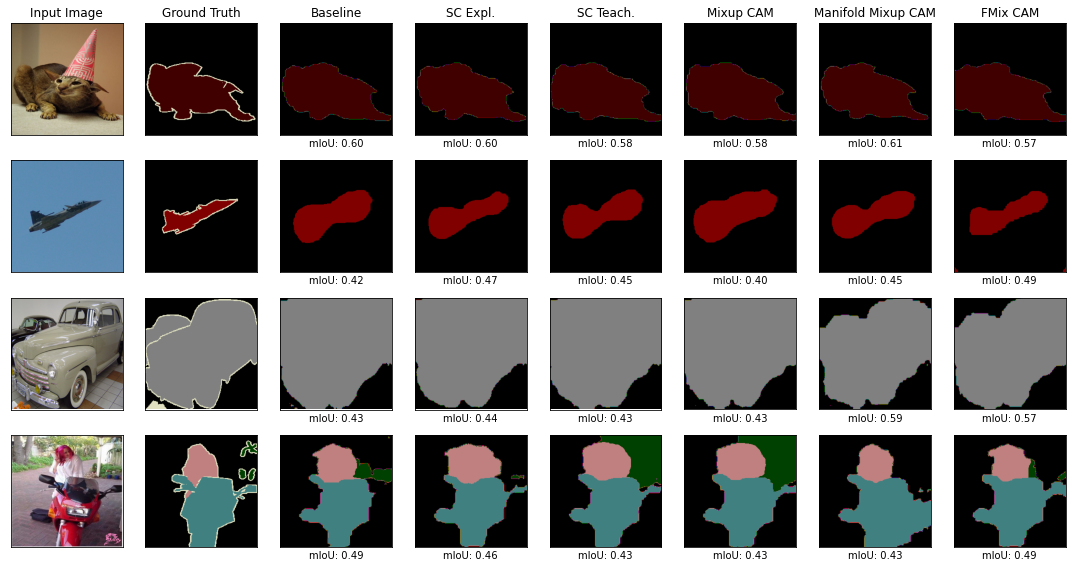

In [24]:
from evaluate_cams import calc_semantic_segmentation_confusion, calc_semantic_segmentation_iou

ncols=8
nrows=4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))
cmap = color_map()[:, np.newaxis, :]

for i in range(nrows):
    for j in range(2):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].grid(False)
        ax[i, j].imshow(data_train[random_idx[i]][j].resize((224, 224)))

    label = np.array(data_train[random_idx[i]][1])
    id = os.path.splitext(os.path.basename(data_train_path.iloc[random_idx[i]]))[0]
    offset=2
    for j in range(6):
        filename = os.path.join(rw_dirs[j], id + '.png')
        target = np.array(Image.open(filename).resize((224, 224)))
        target = target[:, :, np.newaxis]
        ax[i, offset+j].set_xticks([])
        ax[i, offset+j].set_yticks([])
        ax[i, offset+j].grid(False)

        new_im = np.dot(target == 0, cmap[0])
        for _ in range(1, cmap.shape[0]):
            new_im += np.dot(target == _, cmap[_])
        new_im = Image.fromarray(new_im.astype(np.uint8))
        
        target = np.array(Image.open(filename))
        confusion = calc_semantic_segmentation_confusion([target], [label])

        iou = calc_semantic_segmentation_iou(confusion)
        
        ax[i, offset+j].imshow(new_im)
        ax[i, offset+j].set_xlabel('mIoU: {0:0.2f}'.format(np.nanmean(iou)))
cols = ['Input Image',
        'Ground Truth',
        'Baseline',
        'SC Expl.',
        'SC Teach.',
        'Mixup CAM',
        'Manifold Mixup CAM',
        'FMix CAM']
plt.subplots_adjust(wspace=0, hspace=0)
        
for a, col in zip(ax[0], cols):
    a.set_title(col)
    
fig.tight_layout()
plt.savefig('Figure/Figure7.jpg')

## Figure 7

In [17]:
rw_dirs = ["experiment/baseline/seg_map",
          'experiment/sct/seg_map',
          'experiment/manifold_mixup/seg_map',
          "experiment/mixup/seg_map",
          'experiment/sce/seg_map',
          'experiment/fmix/seg_map',]

rw_paths = []
for rw_dir in rw_dirs:
    rw_paths.append(sorted(os.listdir(rw_dir)))

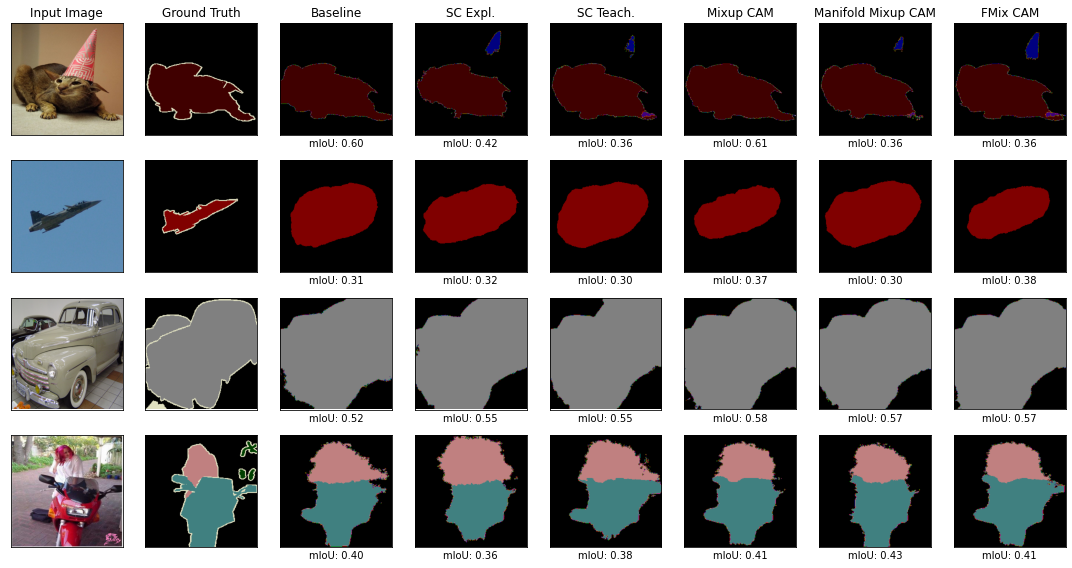

In [19]:
from evaluate_cams import calc_semantic_segmentation_confusion, calc_semantic_segmentation_iou

ncols=8
nrows=4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))
cmap = color_map()[:, np.newaxis, :]

for i in range(nrows):
    for j in range(2):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].grid(False)
        ax[i, j].imshow(data_train[random_idx[i]][j].resize((224, 224)))

    label = np.array(data_train[random_idx[i]][1])
    id = os.path.splitext(os.path.basename(data_train_path.iloc[random_idx[i]]))[0]
    offset=2
    for j in range(6):
        filename = os.path.join(rw_dirs[j], id + '.png')
        target = np.array(Image.open(filename).resize((224, 224)))
        target = target[:, :, np.newaxis]
        ax[i, offset+j].set_xticks([])
        ax[i, offset+j].set_yticks([])
        ax[i, offset+j].grid(False)

        new_im = np.dot(target == 0, cmap[0])
        for _ in range(1, cmap.shape[0]):
            new_im += np.dot(target == _, cmap[_])
        new_im = Image.fromarray(new_im.astype(np.uint8))
        
        target = np.array(Image.open(filename))
        confusion = calc_semantic_segmentation_confusion([target], [label])

        iou = calc_semantic_segmentation_iou(confusion)
        
        ax[i, offset+j].imshow(new_im)
        ax[i, offset+j].set_xlabel('mIoU: {0:0.2f}'.format(np.nanmean(iou)))
cols = ['Input Image',
        'Ground Truth',
        'Baseline',
        'SC Expl.',
        'SC Teach.',
        'Mixup CAM',
        'Manifold Mixup CAM',
        'FMix CAM']
plt.subplots_adjust(wspace=0, hspace=0)
        
for a, col in zip(ax[0], cols):
    a.set_title(col)
    
fig.tight_layout()
plt.savefig('Figure/Figure8.jpg')